In [35]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential,models,layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
import pathlib
from glob import glob
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data Reading/Data Understanding
Setting the path for train and test images.
This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [36]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')


In [37]:
image_count_test = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_test)
image_count_train = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_train)

2239
118


In [38]:
# Defining parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

## Use 80% of the images for training, and 20% for validation.

In [39]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                                seed=123,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [40]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [41]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [42]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation
Creating a code to visualize one instance of all the nine classes present in the dataset

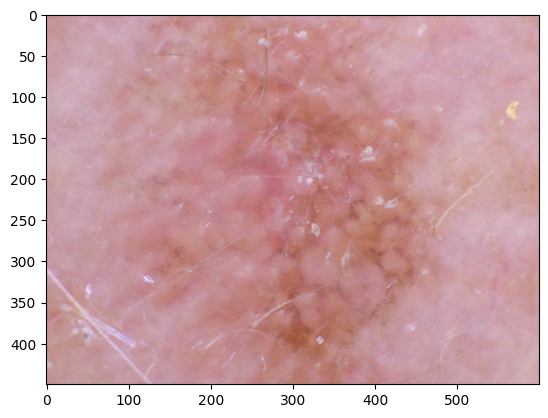

In [43]:
import matplotlib.pyplot as plt
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

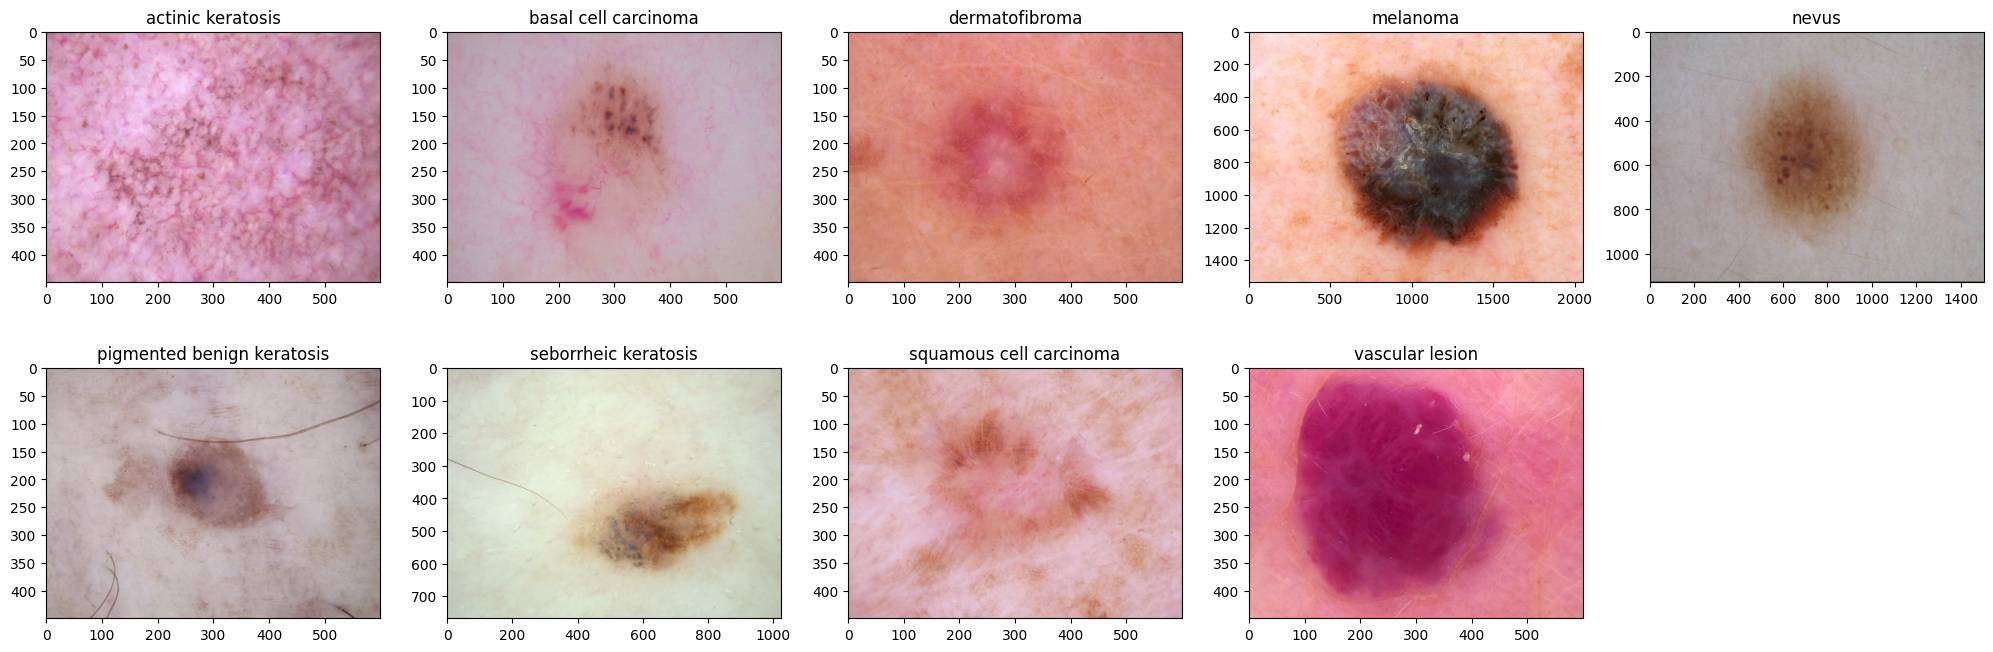

In [44]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [45]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch./
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [46]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Model Building & training :
1.  Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2.  Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
3.  Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [47]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [48]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 259200)           

In [49]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 159ms/step - loss: 3.7175 - accuracy: 0.2506 - val_loss: 1.7020 - val_accuracy: 0.4385
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.5788 - accuracy: 0.4526 - val_loss: 1.6584 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 1.4797 - accuracy: 0.4944 - val_loss: 1.4138 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.2831 - accuracy: 0.5530 - val_loss: 1.4131 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.2227 - accuracy: 0.5631 - val_loss: 1.3852 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.1407 - accuracy: 0.5943 - val_loss: 1.6125 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 0.9751 - accuracy: 0.6501 - val_loss: 1.5875 - val_accuracy: 0.4586
Epoch 8/20


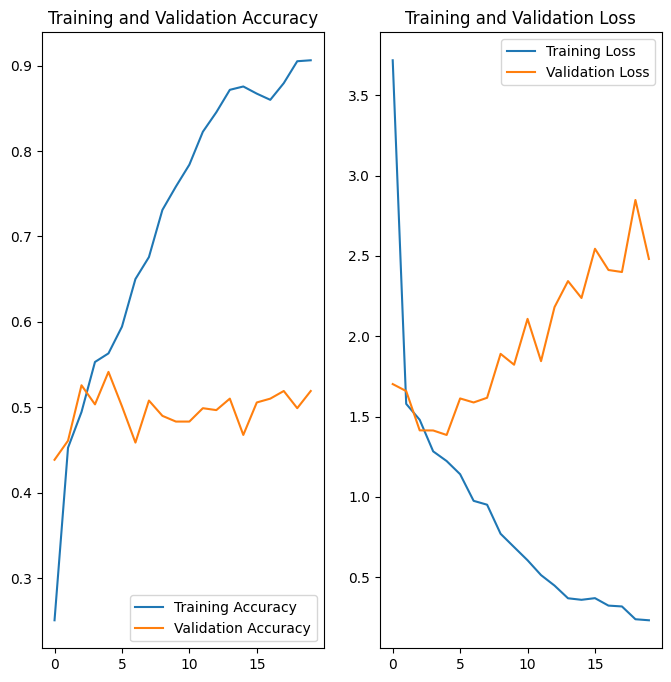

In [50]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [51]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

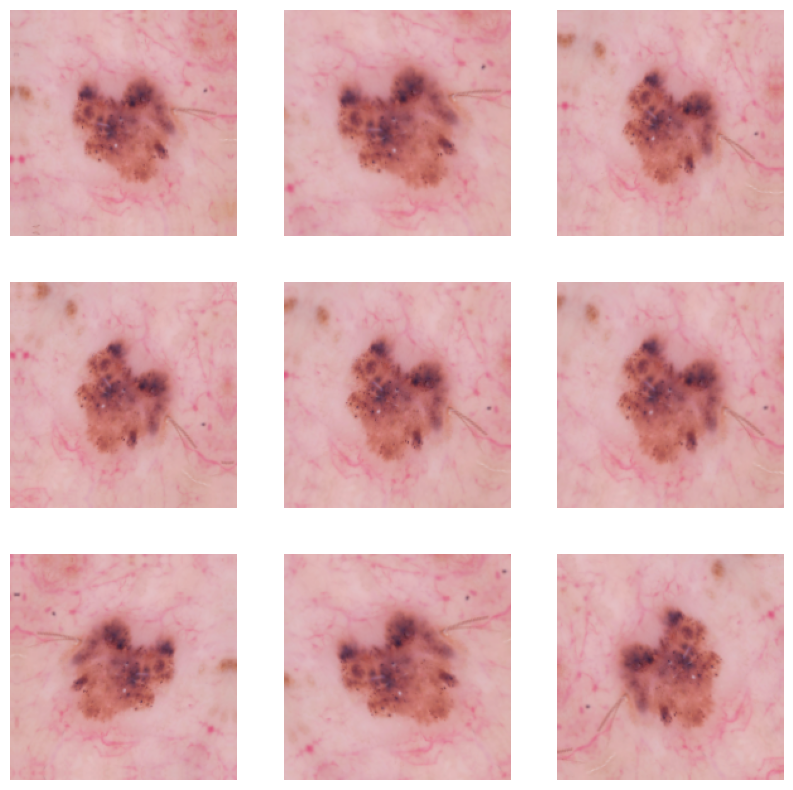

In [52]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data :
1.  Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2.  Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
3.  Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [53]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [54]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [55]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 77ms/step - loss: 3.4270 - accuracy: 0.2260 - val_loss: 1.8225 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 4s 73ms/step - loss: 1.7609 - accuracy: 0.3817 - val_loss: 1.6034 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.6098 - accuracy: 0.4531 - val_loss: 1.5007 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4881 - accuracy: 0.4911 - val_loss: 1.4852 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.4437 - accuracy: 0.5011 - val_loss: 1.4020 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4215 - accuracy: 0.5039 - val_loss: 1.4251 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3797 - accuracy: 0.5095 - val_loss: 1.3734 - val_accuracy: 0.5481
Epoch 8/20
56

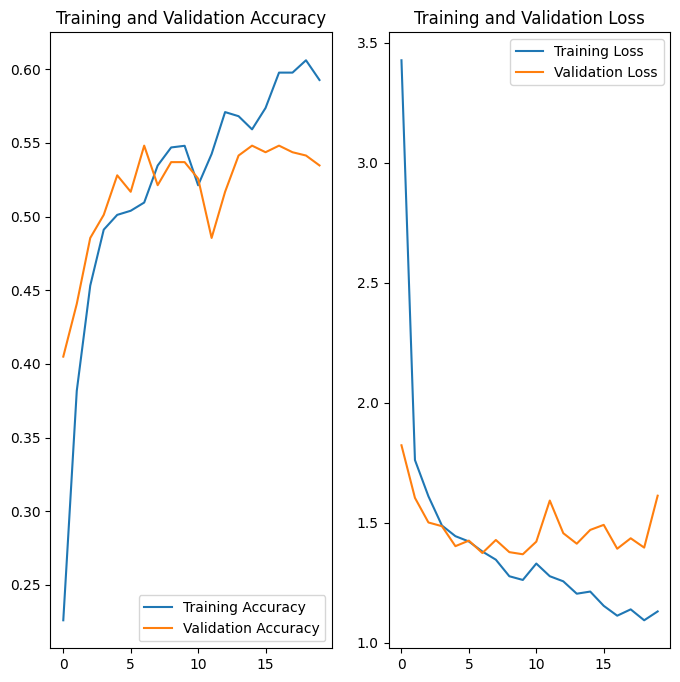

In [56]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

# Observations :
1.   As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2.   As the training loss decreases with epochs the validation loss decreases and stalls.
3.  The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

# Model Building & training on the augmented data with dropout :

*   Creating a CNN model, which can accurately detect 9 classes present in the dataset.
*   While building the model, rescaling images to normalize pixel values between (0,1).
*   Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
*   Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [57]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [58]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 128)      0         
 g2D)                                                 

In [59]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 110ms/step - loss: 3.0280 - accuracy: 0.2204 - val_loss: 1.8789 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 1.8082 - accuracy: 0.3393 - val_loss: 1.6780 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 1.6022 - accuracy: 0.4386 - val_loss: 1.4929 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 6s 106ms/step - loss: 1.4754 - accuracy: 0.4777 - val_loss: 1.4176 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 6s 104ms/step - loss: 1.4256 - accuracy: 0.4905 - val_loss: 1.4142 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 6s 104ms/step - loss: 1.3696 - accuracy: 0.5162 - val_loss: 1.4283 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 6s 104ms/step - loss: 1.3383 - accuracy: 0.5290 - val_loss: 1.3554 - val_accuracy: 0.5280
Epoch 

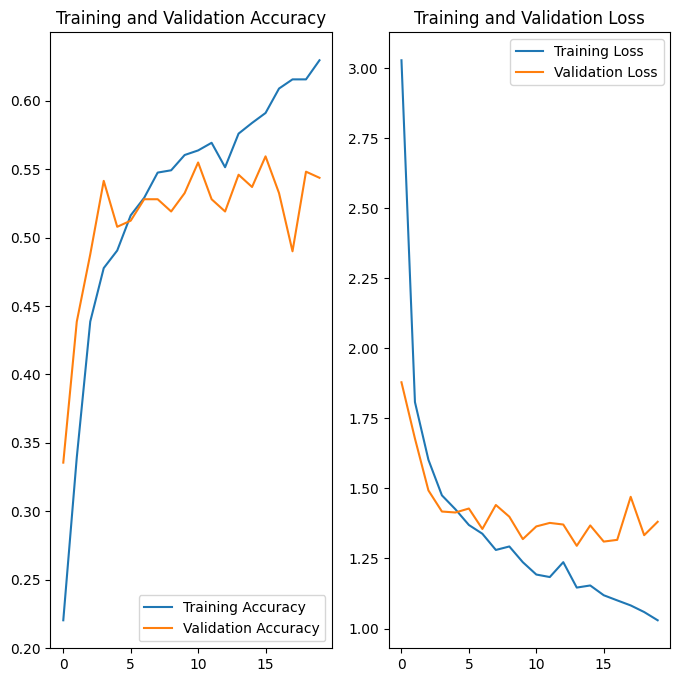

In [60]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

#Observations :
1.  As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2.  As the training loss decreases with epochs the validation loss decreases
The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
3. The difference in accuracy between training and validation accuracy is very less

# Conclusion
We can clearly see that the overfitting of the model has redused significantly when compared the earlier models

# Class distribution:
* Examining the current class distribution in the training dataset

* Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

* Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [61]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


# Observations and inferences :
1.  Which class has the least number of samples?
    ->seborrheic keratosis with 77 samples
2.  Which classes dominate the data in terms proportionate number of samples?
    ->pigmented benign keratosis with 462 samples

# Handling class imbalances:
Rectifying class imbalances present in the training dataset with Augmentor library.



In [62]:
!pip install Augmentor

In [65]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD4A145CEE0>: 100%|██████████| 500/500 [00:24<00:00, 20.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BD4A15288B0>: 100%|██████████| 500/500 [00:20<00:00, 23.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BD4B90CBAF0>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BD4B08DA860>: 100%|██████████| 500/500 [01:43<00:00,  4.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7BD4B8EE17E0>: 100%|██████████| 500/500 [01:53<00:00,  4.39 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BD4A14A5F60>: 100%|██████████| 500/500 [00:21<00:00, 23.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7BD4A0482D40>: 100%|██████████| 500/500 [00:51<00:00,  9.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD4B095A320>: 100%|██████████| 500/500 [00:21<00:00, 23.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BD4A14A6F20>: 100%|██████████| 500/500 [00:23<00:00, 21.02 Samples/s]


In [66]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Newly generated images with the Augmentor library:", image_count_train)

Newly generated images with the Augmentor library: 4500


Checking the distribution of augmented data after adding new images to the original training data.

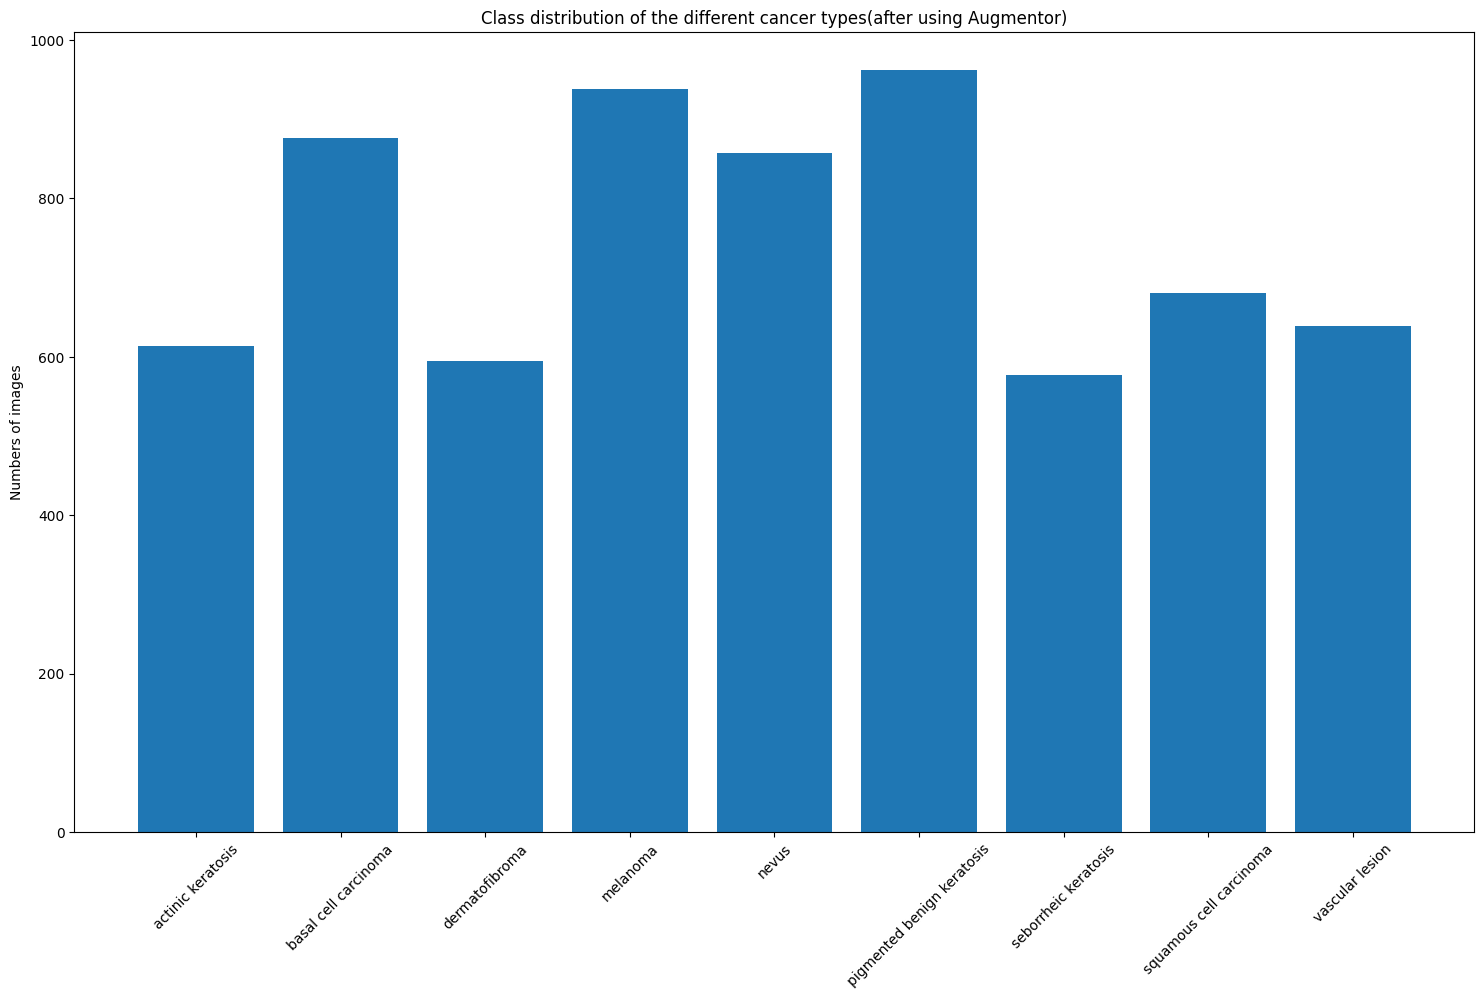

In [67]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()



# Observation:
We have added 500 images to all the classes to maintain some class balance. Thus, now there are enough samples to analyze our model.

Let's create a training and validation dataset with our new samples

In [69]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [71]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [72]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
# CNN Model on the data created using Augmentor
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [74]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)      

In [75]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 51s 120ms/step - loss: 1.9608 - accuracy: 0.2778 - val_loss: 1.4669 - val_accuracy: 0.4684
Epoch 2/20
169/169 [==============================] - 10s 59ms/step - loss: 1.5359 - accuracy: 0.4280 - val_loss: 1.3776 - val_accuracy: 0.4833
Epoch 3/20
169/169 [==============================] - 10s 58ms/step - loss: 1.3363 - accuracy: 0.5006 - val_loss: 1.2979 - val_accuracy: 0.5278
Epoch 4/20
169/169 [==============================] - 10s 60ms/step - loss: 1.1428 - accuracy: 0.5816 - val_loss: 1.0199 - val_accuracy: 0.6065
Epoch 5/20
169/169 [==============================] - 10s 58ms/step - loss: 0.9946 - accuracy: 0.6287 - val_loss: 0.9669 - val_accuracy: 0.6548
Epoch 6/20
169/169 [==============================] - 10s 58ms/step - loss: 0.8198 - accuracy: 0.6983 - val_loss: 0.8601 - val_accuracy: 0.7164
Epoch 7/20
169/169 [==============================] - 10s 58ms/step - loss: 0.7360 - accuracy: 0.7302 - val_loss: 0.7346 - val_accuracy

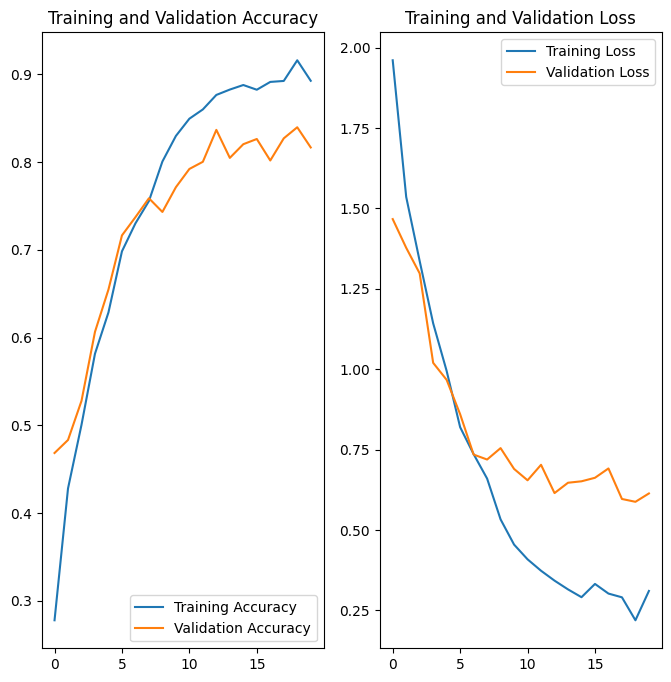

In [77]:
#visualize the results of model
plot_cnn_metrics(history, epochs)

### Observation

1. With the increase in the training accuracy over time, where as the validation accuracy also increases.
2. The validation loss also decreases over time.
3. The gap between training accuracy and validation accuracy has decreased significantly compared to the previous model, and it has achieved around 84% accuracy on the validation set.

# Conclusion
Thus, Class rebalacing improved the overall accuracy and reduced the overall loss for the model